<a href="https://colab.research.google.com/github/pvn-leo/DataAnalytics/blob/master/EndToEnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


# Inits + Imports

In [2]:
cd

/root


In [3]:
cd /content/drive/My Drive/da5

/content/drive/My Drive/da5


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

In [5]:
df = pd.read_csv('./US_Accidents_June20.csv')
#df.columns = map(str.lower, df.columns)

In [6]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.weekday
df['Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds()/60
#dropping duplicates + duration= [0,1] week
oneweek = 7 * 24 * 60

In [7]:
df_clean = df[(df['Duration']>0) & (df['Duration']< oneweek)].drop_duplicates(subset=['Start_Time','End_Time','City','Street','Number','Description'])

# <b>Cleaning</b>

### Dropping columns

<b> Reasons for dropping the respective columns:</b>  
1. ```Source``` - Just because an accident was reported by a particular source doesn't influence the accident in no way.
2. ```ID``` - Being a unique number for an accident has no impact on accident  
3. ```TMC``` - Inferred attribute from accident
4. ```Description``` - Inferred attribute from accident
5. ```Distance(mi)``` - the length of road affected by road accident doesn't really influence accident causation and they are inferred attributes.
6. ```End_Time``` - obtained only after accident occurs (we already have the timestamp)
7. ```End_Lat``` - obtained only after accident occurs (we already have start_lat and start_lng)
8. ```End_Lng``` - obtained only after accident occurs
9. ```Country``` - univalued i.e 'US'
10. ```Turning_Loop``` - univalued i.e 'false'
11. ```Weather_Timestamp``` - Timestamped data, talks more about weather observation time, rather than giving insights on accident occurences


In [8]:
df_clean = df_clean.drop(['Source', 'ID','TMC','Description', 'Distance(mi)','Duration', 'End_Time', 'End_Lat', 'End_Lng', 'Country','Turning_Loop', 'Weather_Timestamp' ], axis=1)
#df_clean = df_clean.drop(['Number','Wind_Chill(F)'], axis=1) done in the next

### Missing data

12. ```Number``` -  64.4% missing data
13. ```Wind_Chill``` - 53.3% missing data

In [9]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
        

In [10]:
missing_values_table(df_clean)

The dataframe has 42 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
Number,2249747,64.4
Precipitation(in),2017879,57.8
Wind_Chill(F),1860561,53.3
Wind_Speed(mph),452590,13.0
Weather_Condition,75443,2.2
Visibility(mi),75159,2.2
Humidity(%),69195,2.0
Temperature(F),65270,1.9
Wind_Direction,58145,1.7
Pressure(in),55492,1.6


In [11]:
#drop 'Number' and 'Wind_Chill(F)' since missing value % > 50
df_clean = df_clean.drop(['Number','Wind_Chill(F)'], axis=1)

In [12]:
#For all those attributes with < 50% the method used is dropna() where null rows are just dropped. Ignoring such columns as a whole will immensely impact predictions
df_clean = df_clean.dropna(subset=['City','Astronomical_Twilight','Nautical_Twilight', 'Civil_Twilight', 'Sunrise_Sunset', 'Zipcode','Timezone','Airport_Code'])

### Imputations

Mean imputations   (continous) - ```Temperature(F), Pressure(in), Humidity(%)```  
Median imputations (continous) - ```Visibility(mi), Wind_Speed(mph)```  
Modal imputations  (categorical)  - ```Weather_Codition, Wind_Direction```

In [13]:
#Mean/Median imputations
df_clean['Temperature(F)'] = df_clean['Temperature(F)'].fillna((df_clean['Temperature(F)'].mean()))
df_clean['Pressure(in)'] = df_clean['Pressure(in)'].fillna((df_clean['Pressure(in)'].mean()))
df_clean['Humidity(%)'] = df_clean['Humidity(%)'].fillna((df_clean['Humidity(%)'].mean()))
df_clean['Visibility(mi)'] = df_clean['Visibility(mi)'].fillna((df_clean['Visibility(mi)'].median()))
df_clean['Wind_Speed(mph)'] = df_clean['Wind_Speed(mph)'].fillna((df_clean['Wind_Speed(mph)'].median()))

In [14]:
#modal imputations
weather_cond_mode = (df_clean['Weather_Condition'].mode())
df_clean["Weather_Condition"].fillna(weather_cond_mode[0], inplace=True)

weather_cond_mode = (df_clean['Wind_Direction'].mode())
df_clean["Wind_Direction"].fillna(weather_cond_mode[0], inplace=True)

In [15]:
#lets see what to do about this
df_clean = df_clean.drop(['Precipitation(in)'], axis = 1 )

In [16]:
missing_values_table(df_clean)

The dataframe has 39 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Dropping some more tables

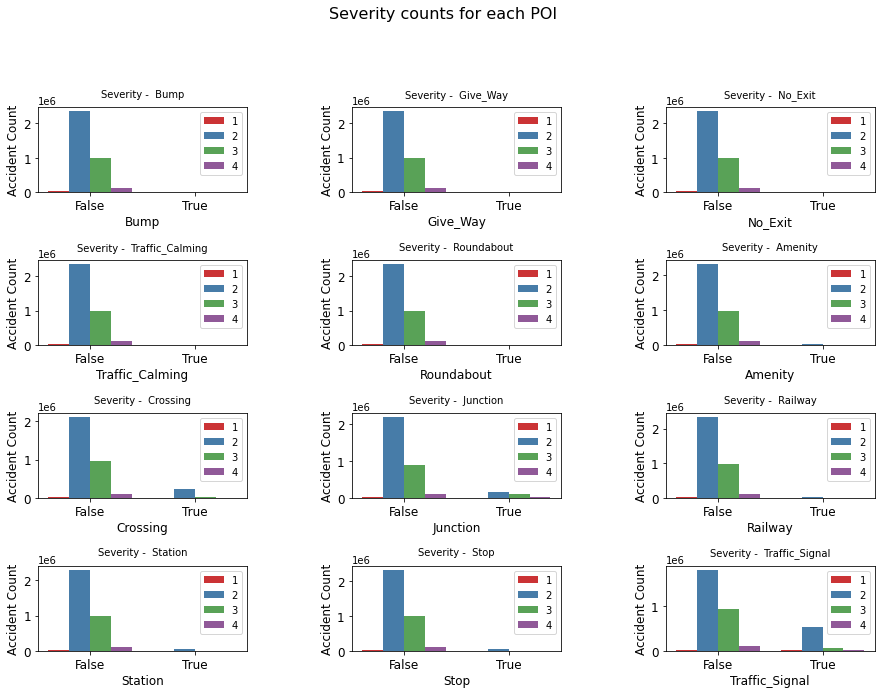

In [17]:
#POI Features from kaggle website https://www.kaggle.com/sobhanmoosavi/us-accidents
POI = ['Bump', 'Give_Way', 'No_Exit', 'Traffic_Calming', 'Roundabout', 'Amenity', 'Crossing','Junction', 'Railway','Station','Stop','Traffic_Signal']

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.8,wspace = 0.5)

for i, feature in enumerate(POI, 1):    
    plt.subplot(4, 3, i)
    sns.countplot(x=feature, data=df_clean, hue='Severity', palette="Set1")
    
    plt.xlabel('{}'.format(feature), size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(['1','2','3','4'], prop={'size': 10}, loc='upper right')
    plt.title('Severity -  {}'.format(feature), size=10, y = 1.05)
fig.suptitle('Severity counts for each POI',y=1.02, fontsize=16)
plt.show()

As it can be seen from the above subplots and even evident through the dataset overview on kaggle, ```'Bump','Give_Way','No_Exit','Roundabout','Traffic_Calming'``` have no visible/significant True values indicating whether that POI feature played a part in accident occurance.

| POI_Features | True | False |
| --------------- | --------------- | --------------- |
| Bump | 606 (0%) | 3.51m (100%) |
| Give_Way | 9564 (0%) | 3.51m (100%) |
| No_Exit  | 4384 (0%) | 3.51m (100%) |
| Roundabout  | 184 (0%) | 3.51m (100%) |
| Traffic_Calming  | 1401 (0%) | 3.51m (100%) |


It can be seen that if these POI features were False then more accidents occured and it would make the model biased to the False values of these attributes in predicting an accident. All these attributes have True accounted for almost 100% of the data and False account for approx 0%.

Hence it would be right to drop the attributes itself.  
<br/>
<br/>
```Civil_twilight, Nautical_Twilight, Astronomical_Twilight``` have many rows with same values for each attribute. These three columns just shows the period of the day (i.e day or night) based on Civil, Nautical and Astronomical twilight. But since we are already accounting for ```Sunrise_Sunset```, which shows the period of the day based on sunrise/sunset, the other three columns account for duplicate meanings/data and also show high correlation against each other. [This is from the description of the dataset on kaggle]  


Since we are already accounting for ```Month, Hour, Weekday``` attributes we are dropping the ```Start_Time, Year``` as well.  

```County, Airport_Code, Zip_Code``` are dropped upon feature selection and trial and error based model predictions.

In [18]:
df_clean= df_clean.drop(['Bump','Give_Way','No_Exit','Roundabout','Traffic_Calming'], axis=1)
df_clean = df_clean.drop(['Civil_Twilight', 'Nautical_Twilight','Astronomical_Twilight'], axis=1)
df_clean = df_clean.drop(['Start_Time'], axis = 1)
df_clean = df_clean.drop(['Zipcode','Airport_Code','Year'], axis=1)
df_clean = df_clean.drop(['County'], axis = 1)
#df_clean = df_clean.drop(['Month', 'Hour', 'Weekday', 'Street', 'City'], axis = 1)

### Scaling + Encoding

In [19]:
da = df_clean.copy()

In [20]:
da = da.replace([True, False], [1,0])

In [21]:
da.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Street', 'Side', 'City', 'State',
       'Timezone', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Crossing', 'Junction', 'Railway',
       'Station', 'Stop', 'Traffic_Signal', 'Sunrise_Sunset', 'Month', 'Hour',
       'Weekday'],
      dtype='object')

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [23]:
#using pd_getdummies(one hot encoding)
# all of these columns are like binary values true/false, or have atmost 3 unique values
#WARNING : THIS WILL ADD EXTRA COLUMNS TO THE DATSET, since its ONE-HOT encoding
onehotencode = ['Side', 'State', 'Timezone', 'Sunrise_Sunset']
#weekday, wind_direction, month, hour
for i in onehotencode:
    da = pd.concat([da,pd.get_dummies(da[i], prefix=i)],axis=1)
    da.drop([i],axis=1, inplace=True)

In [24]:
numerical_cols = ['Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)']
#normal distribution - mean is 0 and variance is 1, standard scaling
#scaling
for i in numerical_cols:
    scale = StandardScaler().fit(da[[i]])
    #inplace transformation
    da[i] = scale.transform(da[[i]])

In [25]:
#label encoding
#many unique values . 3 for each attribute, hence label encoding
label_encode=['Weather_Condition', 'Wind_Direction', 'Month', 'Hour', 'Weekday', 'Street', 'City']
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
for i in label_encode:
    da[i] = labelencoder.fit_transform(da[i])
    print(i+" done")

Weather_Condition done
Wind_Direction done
Month done
Hour done
Weekday done
Street done
City done


In [26]:
da["Severity"].value_counts()

2    2355543
3     991939
4     109355
1      27110
Name: Severity, dtype: int64

Resampling the datset in order to avoid class imbalance problem

In [27]:
da_re = pd.concat([da[da['Severity']==4].sample(500000, replace = True, random_state=42),
                   da[da['Severity']==3].sample(25000, random_state=42),
                   da[da['Severity']==2].sample(250000, random_state=42),
                   da[da['Severity']==1].sample(7500, replace = True, random_state=42)], axis=0)

da_re["Severity"].value_counts()

4    500000
2    250000
3     25000
1      7500
Name: Severity, dtype: int64

# <b>Model</b>

```
1. Logistic Regression (Baseline)
2. KNN Classifier
3. SVM - runtime disconnected
4. Decision Tree Classifier (Entropy, Gini)
5. Random Forest Classifier - Best among all
6. Neural Network MLP
```

 > Cross validation tests on RFC utilised all the RAM completely and gave a segmentation fault


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import neural_network

import time
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,plot_confusion_matrix, roc_curve, auc
warnings.filterwarnings('ignore')

cv_split = StratifiedKFold(n_splits = 10) #Cross vlidation checking, using K-fold
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(12,6)})

In [29]:
X = da_re.drop('Severity',axis=1)
y = da_re['Severity']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
class_names = list(y.unique())

In [30]:
def check(y_test, y_pred, labels1):
  print(classification_report(y_test, y_pred, labels = labels1))
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred,average='weighted')
  print(f"Accuracy: {acc}\nF1-score: {f1}")

def con_mat_plot(title1, model, X_test, y_test, labels1):
  title = title1
  disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels = labels1,
                                 cmap=plt.cm.Blues)
  disp.ax_.set_title(title)
  print(title)
  print(disp.confusion_matrix)
  plt.grid(b=None)
  plt.show()

### <b><h3>Logistic Regression (Baseline)</h3></b>

In [31]:
lr = LogisticRegression(max_iter=100,random_state=42, verbose = 10)

%time lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 1min 8s, sys: 17.6 s, total: 1min 26s
Wall time: 51.7 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.3s finished


In [32]:
check(y_test, y_pred_lr, da_re.Severity.unique().tolist())

              precision    recall  f1-score   support

           4       0.67      0.88      0.76    100000
           3       0.00      0.00      0.00      5000
           2       0.48      0.24      0.32     50000
           1       0.00      0.00      0.00      1500

    accuracy                           0.64    156500
   macro avg       0.29      0.28      0.27    156500
weighted avg       0.58      0.64      0.59    156500

Accuracy: 0.637482428115016
F1-score: 0.5858502696107868


Logistic Regression Confusion Matrix
[[    0   142     0  1358]
 [    0 11792     0 38208]
 [    0   694     0  4306]
 [    0 12026     0 87974]]


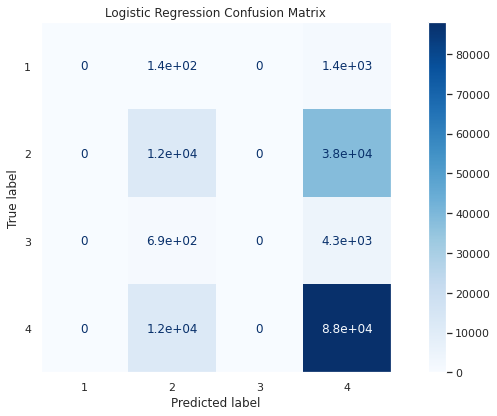

In [33]:
con_mat_plot('Logistic Regression Confusion Matrix', lr, X_test, y_test, class_names.sort())

In [34]:
cv_results = cross_validate(lr, X, y, cv = cv_split,verbose=5,n_jobs=-1,
                           scoring=('accuracy', 'f1_weighted'),
                           return_train_score = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.6min finished


In [35]:
print(f"Average Fit Time: {cv_results['fit_time'].mean()} seconds")
print(f"Average Train Accuracy: {cv_results['train_accuracy'].mean()*100} %")
print(f"Average Test Accuracy: {cv_results['test_accuracy'].mean()*100} %")
print(f"Average Train F1_Score: {cv_results['train_f1_weighted'].mean()*100} %")
print(f"Average Test F1_Score: {cv_results['test_f1_weighted'].mean()*100} %")

Average Fit Time: 78.1673297405243 seconds
Average Train Accuracy: 63.82023429179979 %
Average Test Accuracy: 63.832971246006394 %
Average Train F1_Score: 58.4005349024529 %
Average Test F1_Score: 58.41287926223346 %


### <b><h3>KNN Classifier</h3></b>

In [36]:
knn = KNeighborsClassifier(n_neighbors = 6,n_jobs=-1)

%time knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

CPU times: user 14.1 s, sys: 123 ms, total: 14.2 s
Wall time: 14.2 s


In [37]:
check(y_test, y_pred_knn, da_re.Severity.unique().tolist())

              precision    recall  f1-score   support

           4       0.86      0.94      0.90    100000
           3       0.28      0.05      0.08      5000
           2       0.81      0.74      0.77     50000
           1       0.38      0.19      0.25      1500

    accuracy                           0.84    156500
   macro avg       0.58      0.48      0.50    156500
weighted avg       0.82      0.84      0.83    156500

Accuracy: 0.8402428115015974
F1-score: 0.8260415453448573


KNN Confusion Matrix
[[  286   536     8   670]
 [  285 36858   415 12442]
 [   29  2303   240  2428]
 [  148  5532   206 94114]]


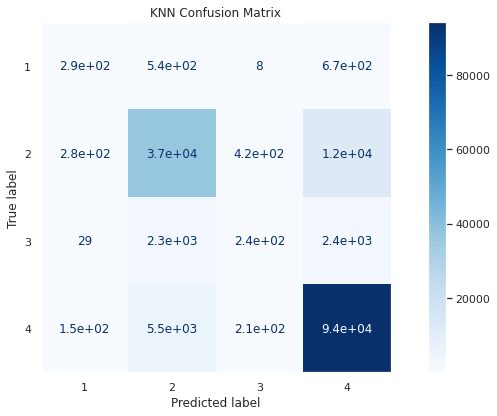

In [38]:
con_mat_plot('KNN Confusion Matrix', knn, X_test, y_test, class_names.sort())

### SVM

takes a lot of time, runtime disconnected

In [39]:
'''
svm = svm.SVC(gamma='auto', verbose = 1)

%time svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
'''

"\nsvm = svm.SVC(gamma='auto', verbose = 1)\n\n%time svm.fit(X_train, y_train)\ny_pred_svm = svm.predict(X_test)\n"

In [40]:
#check(y_test, y_pred_svm, da_re.Severity.unique().tolist())

In [41]:
#con_mat_plot('SVM Confusion Matrix', svm, X_test, y_test, class_names.sort())

### <b><h3>Decision Tree Classifier</h3></b>

In [42]:
dtc_entropy = DecisionTreeClassifier(criterion='entropy')
dtc_gini = DecisionTreeClassifier(criterion='gini')

%time dtc_entropy.fit(X_train, y_train)
y_pred_dtc_entropy= dtc_entropy.predict(X_test)

%time dtc_gini.fit(X_train, y_train)
y_pred_dtc_gini = dtc_gini.predict(X_test)

CPU times: user 18.2 s, sys: 32.4 ms, total: 18.2 s
Wall time: 18.2 s
CPU times: user 18.1 s, sys: 7.29 ms, total: 18.1 s
Wall time: 18.1 s


In [43]:
print("DTC_ENTROPY")
check(y_test, y_pred_dtc_entropy, da_re.Severity.unique().tolist())


print("\nDTC_GINI")
check(y_test, y_pred_dtc_gini, da_re.Severity.unique().tolist())

DTC_ENTROPY
              precision    recall  f1-score   support

           4       0.93      0.99      0.96    100000
           3       0.25      0.20      0.22      5000
           2       0.92      0.81      0.86     50000
           1       0.55      0.55      0.55      1500

    accuracy                           0.91    156500
   macro avg       0.66      0.64      0.65    156500
weighted avg       0.90      0.91      0.90    156500

Accuracy: 0.9057635782747604
F1-score: 0.9016182094584948

DTC_GINI
              precision    recall  f1-score   support

           4       0.93      0.99      0.96    100000
           3       0.24      0.20      0.21      5000
           2       0.92      0.81      0.86     50000
           1       0.53      0.53      0.53      1500

    accuracy                           0.90    156500
   macro avg       0.65      0.63      0.64    156500
weighted avg       0.90      0.90      0.90    156500

Accuracy: 0.9035399361022364
F1-score: 0.899583313

Decision Tree - Gini Matrix
[[  796   435    47   222]
 [  604 40351  3009  6036]
 [   64  2581   983  1372]
 [   24   579   123 99274]]


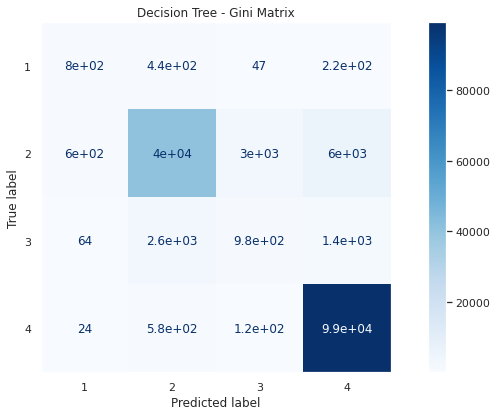

In [44]:
con_mat_plot('Decision Tree - Gini Matrix', dtc_gini, X_test, y_test, class_names.sort())

### <b><h3>Random Forest Classifier</h3></b>

In [45]:
rfc = RandomForestClassifier(n_estimators=150)

%time rfc.fit(X_train,y_train)
y_pred_rfc = rfc.predict(X_test)

CPU times: user 4min 40s, sys: 1.24 s, total: 4min 41s
Wall time: 4min 41s


In [46]:
check(y_test, y_pred_rfc, da_re.Severity.unique().tolist())

              precision    recall  f1-score   support

           4       0.94      1.00      0.97    100000
           3       0.51      0.01      0.02      5000
           2       0.91      0.90      0.91     50000
           1       0.90      0.50      0.65      1500

    accuracy                           0.93    156500
   macro avg       0.82      0.60      0.64    156500
weighted avg       0.92      0.93      0.91    156500

Accuracy: 0.929667731629393
F1-score: 0.9141670878933571


Random Forest Classifier Confusion Matrix
[[  753   498     1   248]
 [   73 45105    54  4768]
 [    3  3332    60  1605]
 [    5   417     3 99575]]


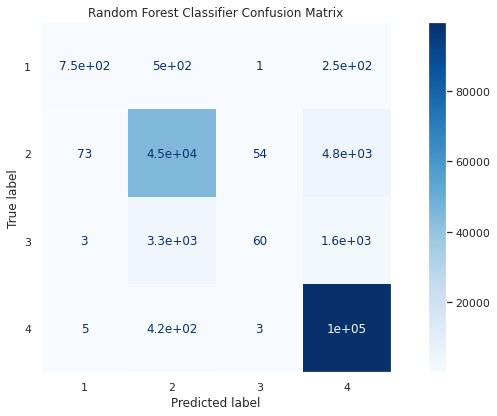

In [47]:
con_mat_plot('Random Forest Classifier Confusion Matrix', rfc, X_test, y_test, class_names.sort())

### Neural Network MLP

In [ ]:
nn = neural_network.MLPClassifier(hidden_layer_sizes=(10, 5, 2), max_iter = 100, verbose = 1, learning_rate='adaptive')

%time nn.fit(X_train,y_train)
y_pred_nn = nn.predict(X_test)

In [55]:
check(y_test, y_pred_nn, da_re.Severity.unique().tolist())

              precision    recall  f1-score   support

           4       0.64      1.00      0.78    100000
           3       0.00      0.00      0.00      5000
           2       0.00      0.00      0.00     50000
           1       0.00      0.00      0.00      1500

    accuracy                           0.64    156500
   macro avg       0.16      0.25      0.19    156500
weighted avg       0.41      0.64      0.50    156500

Accuracy: 0.6389776357827476
F1-score: 0.49822817604892605


Neural Network MLP Confusion Matrix
[[     0      0      0   1500]
 [     0      0      0  50000]
 [     0      0      0   5000]
 [     0      0      0 100000]]


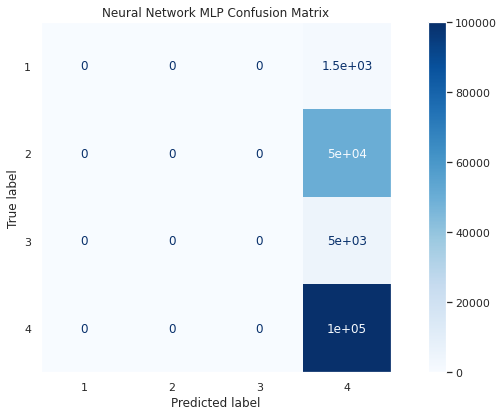

In [57]:
con_mat_plot('Neural Network MLP Confusion Matrix', nn, X_test, y_test, class_names.sort())